In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import shap
import joblib
import cftime

import json

from sklearn.impute import SimpleImputer  # optional if you choose imputation
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler

import esmpy
import sys
import os
import glob

sys.modules['ESMF'] = esmpy

import xesmf as xe

sys.path.append('./scripts')
from data_utils import regrid_to_target

# Create 'figures' folder
os.makedirs("figures", exist_ok=True)

/home/darya/anaconda3/envs/eat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# Function: Decode Time (unchanged)
# ----------------------------
def decode_time(ds, time_var='time'):
    time_num = ds[time_var].values
    time_units = ds[time_var].attrs.get('units', 'seconds since 1970-01-01')
    calendar = ds[time_var].attrs.get('calendar', 'proleptic_gregorian')

    if np.all(time_num > 1e20):
        print(f"All time values in {time_var} are invalid. Skipping decode.")
        full_times = np.full(len(time_num), np.datetime64('NaT'), dtype='datetime64[ns]')
        return ds.assign_coords({time_var: full_times})

    time_num = np.where(time_num > 1e20, np.nan, time_num)
    valid_mask = ~np.isnan(time_num)
    valid_times = time_num[valid_mask]

    decoded = cftime.num2date(valid_times, units=time_units, calendar=calendar)
    full_times = np.full(len(time_num), np.datetime64('NaT'), dtype='datetime64[ns]')
    full_times[valid_mask] = np.array(decoded, dtype='datetime64[ns]')
    return ds.assign_coords({time_var: full_times})

In [3]:
# ----------------------------
# Step 1: Load & Decode Datasets
# ----------------------------

# Load SST dataset without decoding time
ds_sst = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/ERA5_SST_fine_sst_trimmed_rename.nc', decode_times=False)

# Manually assign correct time values for SST (monthly from Feb 1993)
ds_sst['time'] = pd.date_range(start='1993-02-01', periods=370, freq='MS')
sst = ds_sst['sst'] - 273.15

print("SST time dtype:", ds_sst['time'].dtype)

# Load other datasets without decoding time
ds_runoff = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/ERA5_runoff_remapped_Greenland_conservative.nc', decode_times=False)
runoff = ds_runoff['runoff']

ds_sss = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/cmems_obs-mob_glo_phy-sss_my_multi_fine_sos.nc', decode_times=False)
sss = ds_sss['sos']

ds_ssh = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4_fine_sla_trimmed.nc', decode_times=False)
ssh = ds_ssh['sla']

# Decode time for datasets that need it
runoff = decode_time(runoff)
sss = decode_time(sss)
ssh = decode_time(ssh)

# Note: SST time was manually assigned, so decoding is not needed here

print("All data loaded!")

SST time dtype: datetime64[ns]
All data loaded!


In [4]:
# ----------------------------
# Step 2: Align Time
# ----------------------------

def ensure_unique_time(ds):
    # Keep only unique times to avoid duplicates
    _, idx = np.unique(ds.time.values, return_index=True)
    return ds.isel(time=np.sort(idx))

def normalize_time(ds):
    # Convert to pandas datetime, normalize to midnight, assign back
    times = pd.to_datetime(ds.time.values)
    normalized_times = times.normalize()
    return ds.assign_coords(time=normalized_times)

# Remove duplicates from each dataset
sst = ensure_unique_time(sst)
runoff = ensure_unique_time(runoff)
sss = ensure_unique_time(sss).squeeze()
ssh = ensure_unique_time(ssh)

# Normalize time coordinates to midnight for all datasets
sst = normalize_time(sst)
runoff = normalize_time(runoff)
sss = normalize_time(sss)
ssh = normalize_time(ssh)

# Extract normalized times as pd.DatetimeIndex for intersection
sst_times_norm = pd.to_datetime(sst.time.values)
runoff_times_norm = pd.to_datetime(runoff.time.values)
sss_times_norm = pd.to_datetime(sss.time.values)
ssh_times_norm = pd.to_datetime(ssh.time.values)

# Find common intersection of times across all datasets
common_time = sorted(set(sst_times_norm) & set(runoff_times_norm) & set(sss_times_norm) & set(ssh_times_norm))

# Select only the common times from each dataset
sst = sst.sel(time=common_time)
runoff = runoff.sel(time=common_time)
sss = sss.sel(time=common_time)
ssh = ssh.sel(time=common_time)

print(f"Aligned shapes - sst: {sst.shape}, runoff: {runoff.shape}, sss: {sss.shape}, ssh: {ssh.shape}")


Aligned shapes - sst: (370, 525, 601), runoff: (370, 167, 387), sss: (370, 525, 601), ssh: (370, 525, 601)


In [5]:
# ----------------------------
# Step 3: Load AMOC Index Labels 
# ----------------------------

# Load AMOC (overturning transport in unit of Sv) dataset with automatic decoding of time units
amoc_ds = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/moc_transports.nc', decode_times=True)

# Extract AMOC variable and mask invalid values
amoc_var = amoc_ds['moc_mar_hc10'].where(amoc_ds['moc_mar_hc10'] > -9999, np.nan)

# Extract and convert time coordinate to pandas datetime (should be already decoded)
amoc_time = pd.to_datetime(amoc_ds['time'].values)

# Model time from SST dataset
model_time = pd.to_datetime(sst.time.values)

# Align AMOC data to model time by nearest timestamp
amoc_index = pd.Series(amoc_var.values, index=amoc_time).reindex(model_time, method='nearest')

# Define binary target: 1 if AMOC < 15.0 (weakened), else 0
y = (amoc_index < 15.0).astype(int).values

print("Load AMOC Index Labels Done!")

Load AMOC Index Labels Done!


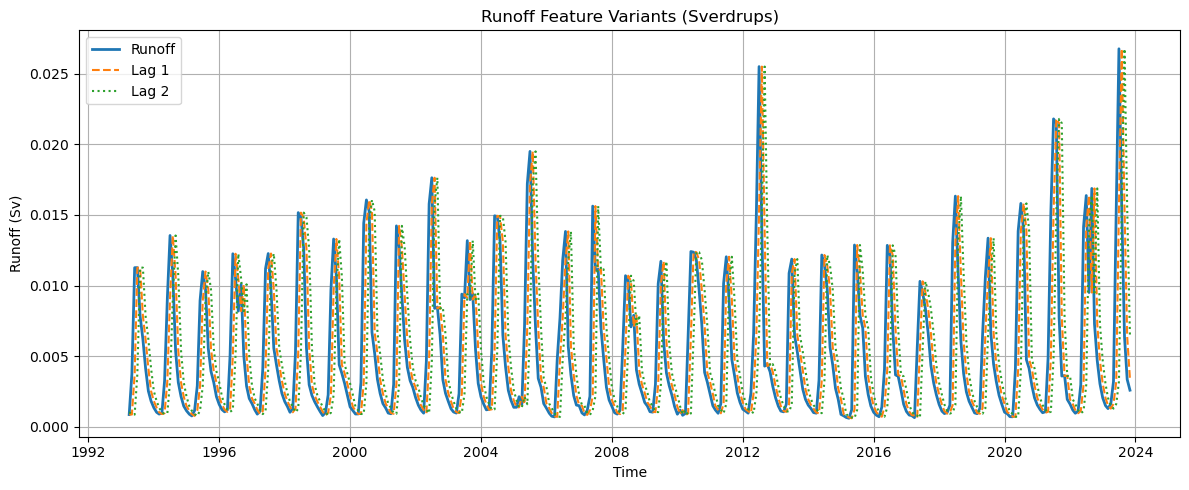

Final input X shape: (368, 476812)
Final label y shape: (368,)


In [6]:
# ----------------------------
# Step 4: Flatten Gridded Data for ML (With Extended Runoff Features)
# ----------------------------

# 1. Flatten spatial grids
n_time, nlat, nlon = sst.shape
sst_flat = sst.values.reshape((n_time, -1))
sss_flat = sss.values.reshape((n_time, -1))
ssh_flat = ssh.values.reshape((n_time, -1))

# 2. Consistent spatial mask (only valid grid points across all variables at time=0)
valid_mask_combined = ~np.isnan(sst_flat[0]) & ~np.isnan(sss_flat[0]) & ~np.isnan(ssh_flat[0])
sst_flat = sst_flat[:, valid_mask_combined]
sss_flat = sss_flat[:, valid_mask_combined]
ssh_flat = ssh_flat[:, valid_mask_combined]

# 3. Drop columns (grid cells) that have any NaN over time
valid_grid_mask = ~np.isnan(sst_flat).any(axis=0) & ~np.isnan(sss_flat).any(axis=0) & ~np.isnan(ssh_flat).any(axis=0)
sst_clean = sst_flat[:, valid_grid_mask]
sss_clean = sss_flat[:, valid_grid_mask]
ssh_clean = ssh_flat[:, valid_grid_mask]

# 4. Save final spatial mask for later reconstruction
np.save("valid_mask_combined.npy", valid_mask_combined)

# --- Runoff features ---
# Sum and normalize runoff to Sverdrups
runoff_sum = np.nansum(runoff.values.reshape(n_time, -1), axis=1).reshape(-1, 1) / 1e6

# Lagged versions
runoff_lag1 = np.roll(runoff_sum, 1)
runoff_lag2 = np.roll(runoff_sum, 2)
runoff_lag1[0] = np.nan
runoff_lag2[:2] = np.nan

# Runoff-SST interaction feature (optional)
sst_mean = np.mean(sst_clean, axis=1, keepdims=True)
runoff_sst_interaction = runoff_sum * sst_mean

# Combine all runoff-derived features
X_runoff = np.concatenate([runoff_sum, runoff_lag1, runoff_lag2, runoff_sst_interaction], axis=1)

# Time-based mask: drop time steps with any NaNs in runoff-derived features
valid_time_mask2 = ~np.isnan(X_runoff).any(axis=1)

# Fix mismatch in y vs valid_time_mask2 length
if len(valid_time_mask2) > len(y):
    valid_time_mask2 = valid_time_mask2[:len(y)]
elif len(y) > len(valid_time_mask2):
    y = y[:len(valid_time_mask2)]

# 5. Final ML input feature matrix
X = np.concatenate([
    sst_clean[valid_time_mask2],
    sss_clean[valid_time_mask2],
    ssh_clean[valid_time_mask2],
    X_runoff[valid_time_mask2]
], axis=1)

# 6. Apply same time mask to labels
y = y[valid_time_mask2]

# 7. Optional: Plot runoff components (for diagnostics)

plt.figure(figsize=(12, 5))

plt.plot(sst_times_norm[valid_time_mask2], X_runoff[valid_time_mask2][:, 0], label='Runoff', linewidth=2)
plt.plot(sst_times_norm[valid_time_mask2], X_runoff[valid_time_mask2][:, 1], label='Lag 1', linestyle='--')
plt.plot(sst_times_norm[valid_time_mask2], X_runoff[valid_time_mask2][:, 2], label='Lag 2', linestyle=':')

plt.title('Runoff Feature Variants (Sverdrups)')
plt.xlabel('Time')
plt.ylabel('Runoff (Sv)')
plt.legend()
plt.grid(True)
plt.tight_layout()

#plt.savefig("figures/runoff_feature_variants.png", dpi=300)
#plt.close()

plt.show()

print("Final input X shape:", X.shape)
print("Final label y shape:", y.shape)


In [7]:
# ----------------------------
# Step 5: PCA + Train/Test Split + SMOTE
# ----------------------------

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = IncrementalPCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

print("Standardize features & PCA applied!")

Standardize features & PCA applied!


In [8]:
# ----------------------------
# Step 6: Train/Test Split, Handle Imbalance, Train & Save Model
# ----------------------------
# 6.1 - Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Before SMOTE:")
print("  - Class distribution in y_train:", np.bincount(y_train))
print("  - Class distribution in y_test :", np.bincount(y_test))


Before SMOTE:
  - Class distribution in y_train: [219  38]
  - Class distribution in y_test : [94 17]


In [9]:
# 6.2 - Standardize (Scale)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

joblib.dump(X_train_scaled, "X_train_scaled.pkl")
print("X train scaled saved as 'X_train_scaled.pkl'")

Scaler saved as 'scaler.pkl'
X train scaled saved as 'X_train_scaled.pkl'


In [10]:
# 6.3 - Apply PCA  Befor run this section make sure you run externally in terminal $ python apply_pca.py to creat pca_model.pkl file

# Load previously saved PCA model
ipca = joblib.load("pca_model.pkl")      # make sure run already $ python apply_pca.py

# Transform the scaled training and test data
X_train_pca = ipca.transform(X_train_scaled)
X_test_pca = ipca.transform(X_test_scaled)

print("PCA transformation applied successfully.")
print("  - X_train_pca shape:", X_train_pca.shape)
print("  - X_test_pca shape :", X_test_pca.shape)

joblib.dump(X_train_pca, "X_train_pca.pkl")
joblib.dump(X_test_pca, "X_test_pca.pkl")
print("PCA-transformed data saved.")

PCA transformation applied successfully.
  - X_train_pca shape: (257, 30)
  - X_test_pca shape : (111, 30)
PCA-transformed data saved.


In [11]:
batch_size = 100  # or whatever you used in apply_pca.py

os.makedirs("pca_batches/train", exist_ok=True)

for i in range(0, X_train_scaled.shape[0], batch_size):
    X_batch_pca = ipca.transform(X_train_scaled[i:i+batch_size])
    np.save(f"pca_batches/train/X_train_pca_batch_{i}.npy", X_batch_pca)

print("Transformed training batches saved.")

Transformed training batches saved.


In [12]:
os.makedirs("pca_batches/test", exist_ok=True)

for i in range(0, X_test_scaled.shape[0], batch_size):
    X_batch_pca = ipca.transform(X_test_scaled[i:i+batch_size])
    np.save(f"pca_batches/test/X_test_pca_batch_{i}.npy", X_batch_pca)

print("Transformed testing batches saved.")


Transformed testing batches saved.


In [13]:
# Reconstruct full PCA-transformed train/test data
train_batches = sorted(glob.glob("pca_batches/train/*.npy"))
X_train_pca = np.vstack([np.load(f) for f in train_batches])

test_batches = sorted(glob.glob("pca_batches/test/*.npy"))
X_test_pca = np.vstack([np.load(f) for f in test_batches])

print("Combined train and test PCA batches.")


Combined train and test PCA batches.


In [14]:
# 6.4 - SMOTE (balance only training set)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train)

print("After SMOTE:")
print("  - Class distribution in y_train_bal:", np.bincount(y_train_bal))


After SMOTE:
  - Class distribution in y_train_bal: [219 219]


In [15]:
# 6.5 - Train Random Forest & Save

model = RandomForestClassifier(
    n_estimators=200,
    class_weight=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_bal, y_train_bal)

joblib.dump(model, 'trained_amoc_model.pkl')
print("Model trained and saved as 'trained_amoc_model.pkl'")


joblib.dump(X_train_bal, "X_train_bal.pkl")
joblib.dump(y_train_bal, "y_train_bal.pkl")
joblib.dump(y_test, "y_test.pkl")


Model trained and saved as 'trained_amoc_model.pkl'


['y_test.pkl']

In [16]:
# ----------------------------
# Step 7: Train Model & Feature Importance by Block
# ----------------------------

# Load Train model 
X_train_bal = joblib.load("X_train_bal.pkl")
y_train_bal = joblib.load("y_train_bal.pkl")
X_test_pca = joblib.load("X_test_pca.pkl")
y_test = joblib.load("y_test.pkl")

from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import os

# Use correct preprocessed variables from Step 6
# - X_train_bal: SMOTE-balanced PCA-transformed training data
# - X_test_pca: PCA-transformed test data
# - y_train_bal: SMOTE-balanced labels
# - y_test: test labels from original split

# Double-check they are in memory
print("Shapes check:")
print("  - X_train_bal:", X_train_bal.shape)
print("  - y_train_bal:", y_train_bal.shape)
print("  - X_test_pca :", X_test_pca.shape)
print("  - y_test     :", y_test.shape)

# Train XGBoost model on balanced PCA data
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred = xgb_model.predict(X_test_pca)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC Curve
plt.figure()
RocCurveDisplay.from_estimator(xgb_model, X_test_pca, y_test)
plt.title("ROC Curve")
plt.tight_layout()
plt.savefig("figures/roc_curve.png", dpi=300)
plt.close()

# Plot Precision-Recall Curve
plt.figure()
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_pca, y_test)
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig("figures/precision_recall_curve.png", dpi=300)
plt.close()

print("Plots saved to 'figures/' directory.")


Shapes check:
  - X_train_bal: (438, 30)
  - y_train_bal: (438,)
  - X_test_pca : (111, 30)
  - y_test     : (111,)
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        94
           1       0.35      0.41      0.38        17

    accuracy                           0.79       111
   macro avg       0.62      0.64      0.63       111
weighted avg       0.81      0.79      0.80       111

Plots saved to 'figures/' directory.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
# ----------------------------
# Step 8: Feature Importance by Block
# ----------------------------

# Reconstruct original feature block sizes from Step 5
feature_blocks = {
    'sst': sst_clean.shape[1],
    'sss': sss_clean.shape[1],
    'ssh': ssh_clean.shape[1],
    'runoff': X_runoff.shape[1],  # Should be 4: sum, lag1, lag2, interaction
}

with open('feature_blocks.json', 'w') as f:
    json.dump(feature_blocks, f)
    
# Confirm the total matches the original number of features before PCA
total_features = sum(feature_blocks.values())
assert total_features == X.shape[1], f"Feature count mismatch! Got {total_features}, expected {X.shape[1]}"

# Project PCA components back to original feature space
pca_back = np.abs(pca.components_)  # shape: [n_components, original_features]
mean_pca_contrib = pca_back.mean(axis=0)  # average contribution across components

print("mean_pca_contrib.shape:", mean_pca_contrib.shape)
print("feature_blocks:", feature_blocks)

assert sum(feature_blocks.values()) == mean_pca_contrib.shape[0]
# Compute contribution of each block
block_scores = {}
start = 0
for block, size in feature_blocks.items():
    end = start + size
    block_score = mean_pca_contrib[start:end].sum()
    block_scores[block] = block_score
    start = end

# Normalize to get relative importances
total = sum(block_scores.values())
for k in block_scores:
    block_scores[k] /= total

# Save mean_pca_contrib and block_scores for later use
np.savez('pca_contrib_data.npz', mean_pca_contrib=mean_pca_contrib, block_scores=block_scores)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(block_scores.keys(), block_scores.values(), color='steelblue')
plt.ylabel("Relative Importance")
plt.title("Feature Importance by Block (from PCA contributions)")
plt.tight_layout()
plt.grid(True, axis='y')
plt.savefig('figures/Feature_Importance_by_Block.png', dpi=300)
plt.close()

# Print importance values
for k, v in block_scores.items():
    print(f"{k} block importance: {v:.6f}")



mean_pca_contrib.shape: (476812,)
feature_blocks: {'sst': 158936, 'sss': 158936, 'ssh': 158936, 'runoff': 4}
sst block importance: 0.183357
sss block importance: 0.441600
ssh block importance: 0.375035
runoff block importance: 0.000008


In [18]:
# ----------------------------
# Step 9: SHAP Explainability
# ----------------------------
# Limit sample size due to SHAP memory requirements
sample_size = 100
X_train_sample = X_train_bal[:sample_size]
X_test_sample = X_test_pca[:sample_size]

# SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model, X_train_sample, feature_names=[f'PC{i+1}' for i in range(X_train_bal.shape[1])])

# Compute SHAP values
shap_values = explainer(X_test_sample)

# Plot summary
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/shap_summary.png", dpi=300)
plt.close()

print("SHAP summary plot saved as 'figures/shap_summary.png'.")


SHAP summary plot saved as 'figures/shap_summary.png'.


In [19]:
# ----------------------------
# Step 10: Save for Reproducibility (Updated)
# ----------------------------

np.savez("amoc_ml_input_output.npz",
         X_train_bal=X_train_bal,
         y_train_bal=y_train_bal,
         X_test_pca=X_test_pca,
         y_test=y_test,
         sst_shape=(nlat, nlon),
         valid_mask_combined=valid_mask_combined,
         time=sst_times_norm[valid_time_mask2]  # aligned with masked data
)

print("Saved AMOC ML input/output to 'amoc_ml_input_output.npz'")


Saved AMOC ML input/output to 'amoc_ml_input_output.npz'
